In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, classification_report, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [27]:
df=pd.read_csv('spam.csv',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# EDA

In [28]:
df.shape

(5572, 5)

The dataset has 5572 rows and 5 columns

In [29]:
df.duplicated().sum()

403

403 are duplicated values out of 5572

In [30]:
df.drop_duplicates(inplace=True)

Removed the duplicated values

In [31]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5126
Unnamed: 3    5159
Unnamed: 4    5164
dtype: int64

Null values that has to be removed

In [32]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.rename(columns={'v1':'label','v2':'text'},inplace=True)

Removed the null values and changed the column names for making it easy

In [33]:
df['label'].value_counts()

ham     4516
spam     653
Name: label, dtype: int64

The target variable is unbalanced

# Text Preprocessing

In [34]:
df['label'].replace({'ham':0,'spam':1},inplace=True)

In [35]:
df['text']=df['text'].str.lower()
df['text']=df['text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','email address')
df['text']=df['text'].str.replace(r'http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')
df['text']=df['text'].str.replace(r'£|\$','dollars')
df['text']=df['text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phone number')
df['text']=df['text'].str.replace(r'\d+(\.\d+)?','number')
df['text']=df['text'].str.replace(r'[^\w\d\s]',' ')
df['text']=df['text'].str.replace(r'\s+',' ')
df['text']=df['text'].str.replace(r'^\s+|\s+?$',' ')

In [36]:
stop_words=set(stopwords.words('english')+['u','ur','4','2','im','dont','doin','ure'])
df['text']=df['text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

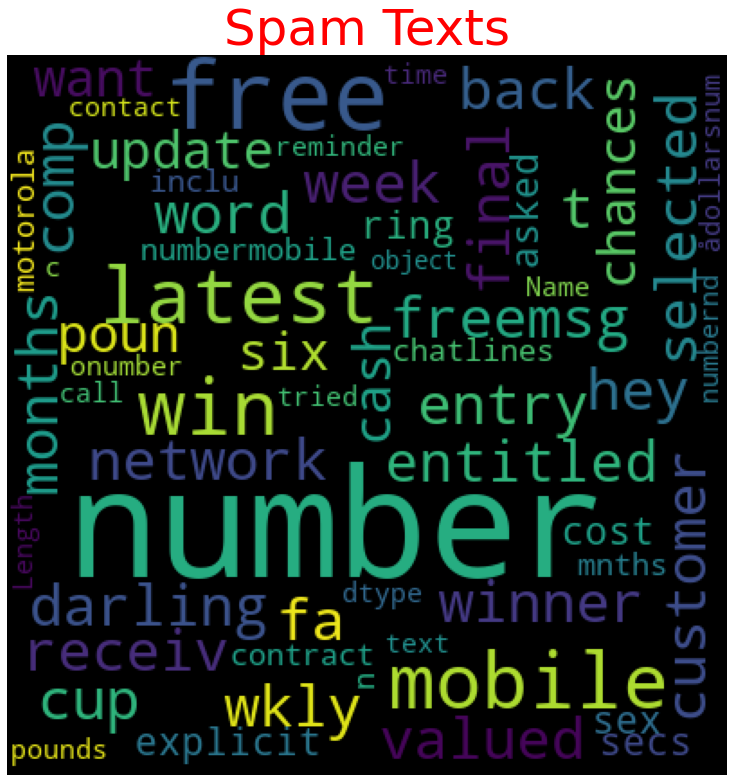

In [37]:
spam=df[(df['label']==1)]

wordcloud=WordCloud(height=400,width=400,max_words=400).generate(str(spam['text']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='Spam Texts',fontdict={'fontsize':50, 'fontweight':50, 'color':'red'})
plt.show()

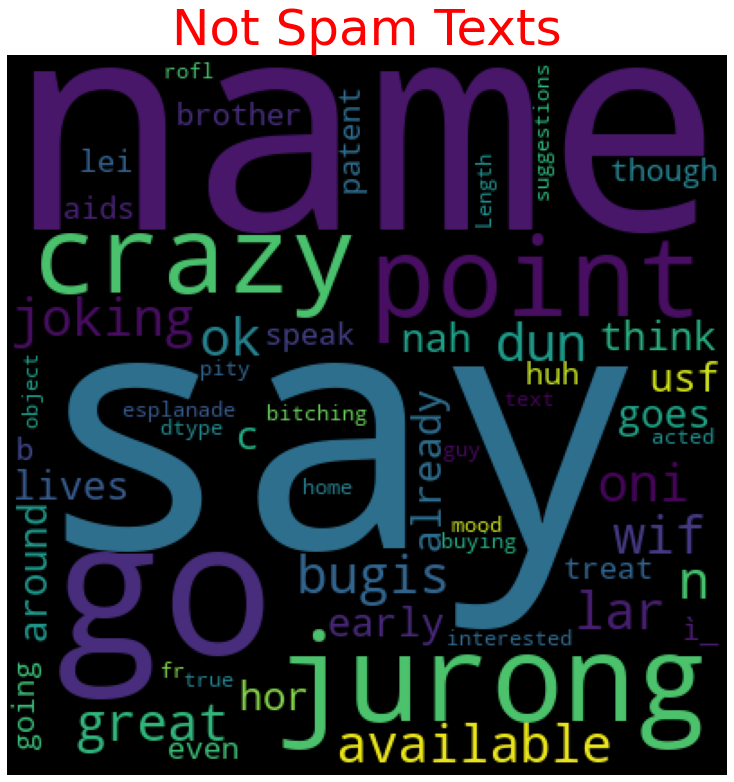

In [39]:
notspam=df[(df['label']==0)]

wordcloud=WordCloud(height=400,width=400,max_words=400).generate(str(notspam['text']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='Not Spam Texts',fontdict={'fontsize':50, 'fontweight':50, 'color':'red'})
plt.show()

# Model Training and Development

In [40]:
X=df['text']
y=df['label']

Splitting dataset into features and labels

In [43]:
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(X)

In [44]:
y.value_counts()

0    4516
1     653
Name: label, dtype: int64

In [45]:
from imblearn.over_sampling import SMOTE
SM=SMOTE()
X,y=SM.fit_resample(X,y)

y.value_counts()

1    4516
0    4516
Name: label, dtype: int64

The dataset is now balanced

### Finding best random state

In [46]:
maxAccu=0
maxRs=0
for i in range(1,200):
    X_train,x_test,Y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=i)
    mod=DecisionTreeClassifier()
    mod.fit(X_train,Y_train)
    pred=mod.predict(x_test)
    acc=accuracy_score(y_test,pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRs=i
print("Best accuracy is:",maxAccu,"on Random State",maxRs)

Best accuracy is: 0.9889282550930026 on Random State 102


In [47]:
X_train,x_test,Y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=102)

## Multiple Model Training

In [48]:
DTC=DecisionTreeClassifier()
DTC.fit(X_train,Y_train)
pred=DTC.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1155
           1       0.98      0.99      0.99      1103

    accuracy                           0.99      2258
   macro avg       0.99      0.99      0.99      2258
weighted avg       0.99      0.99      0.99      2258



In [49]:
lr=LogisticRegression()
lr.fit(X_train,Y_train)
pred=lr.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1155
           1       0.99      0.98      0.99      1103

    accuracy                           0.99      2258
   macro avg       0.99      0.99      0.99      2258
weighted avg       0.99      0.99      0.99      2258



In [50]:
RFC=RandomForestClassifier()
RFC.fit(X_train,Y_train)
pred=RFC.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1155
           1       1.00      0.99      1.00      1103

    accuracy                           1.00      2258
   macro avg       1.00      1.00      1.00      2258
weighted avg       1.00      1.00      1.00      2258



In [51]:
SV=SVC()
SV.fit(X_train,Y_train)
pred=SV.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1155
           1       1.00      1.00      1.00      1103

    accuracy                           1.00      2258
   macro avg       1.00      1.00      1.00      2258
weighted avg       1.00      1.00      1.00      2258



In [52]:
ada=AdaBoostClassifier()
ada.fit(X_train,Y_train)
pred=ada.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1155
           1       0.99      0.98      0.98      1103

    accuracy                           0.98      2258
   macro avg       0.98      0.98      0.98      2258
weighted avg       0.98      0.98      0.98      2258



In [53]:
gbr=GradientBoostingClassifier()
gbr.fit(X_train,Y_train)
pred=gbr.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1155
           1       0.99      0.98      0.98      1103

    accuracy                           0.98      2258
   macro avg       0.98      0.98      0.98      2258
weighted avg       0.98      0.98      0.98      2258



In [54]:
knn=KNeighborsClassifier()
knn.fit(X_train,Y_train)
pred=knn.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1155
           1       1.00      0.99      0.99      1103

    accuracy                           0.99      2258
   macro avg       0.99      0.99      0.99      2258
weighted avg       0.99      0.99      0.99      2258



In [55]:
import xgboost as xgb
xgb=xgb.XGBClassifier()
xgb.fit(X_train,Y_train)
pred=xgb.predict(x_test)
print(classification_report(y_test,pred))

[15:27:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1155
           1       0.99      0.99      0.99      1103

    accuracy                           0.99      2258
   macro avg       0.99      0.99      0.99      2258
weighted avg       0.99      0.99      0.99      2258



In [56]:
mnb=MultinomialNB()
mnb.fit(X_train,Y_train)
pred=mnb.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1155
           1       0.97      1.00      0.98      1103

    accuracy                           0.98      2258
   macro avg       0.98      0.98      0.98      2258
weighted avg       0.98      0.98      0.98      2258



In [57]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(DTC,X,y,cv=5).mean())
print(cross_val_score(RFC,X,y,cv=5).mean())
print(cross_val_score(SV,X,y,cv=5).mean())
print(cross_val_score(lr,X,y,cv=5).mean())
print(cross_val_score(ada,X,y,cv=5).mean())
print(cross_val_score(gbr,X,y,cv=5).mean())
print(cross_val_score(knn,X,y,cv=5).mean())
print(cross_val_score(xgb,X,y,cv=5).mean())
print(cross_val_score(mnb,X,y,cv=5).mean())

0.983172674740351
0.9931374910294102
0.996015066301163
0.9835041039491432
0.9848340494484045
0.9821774065541842
0.993025584643453
[15:37:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly

###### The best Model is Random Forest since it gives the best Accuracy

# Hyperparameter Tuning

In [60]:
parameters={'n_estimators':[200,700],
           'max_features':['auto','sqrt','log2'],
           'criterion':['gini', 'entropy'],
           'max_depth':[4,5,6,7,8],
           'min_samples_split':[2,5],
           'min_samples_leaf':[1,2],
           'bootstrap':[True,False],
           'n_jobs':[-1]}

In [61]:
rfc=RandomForestClassifier()
clf=GridSearchCV(rfc, parameters, cv=5)
clf.fit(X_train,Y_train)

print(clf.best_params_)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 700, 'n_jobs': -1}


In [62]:
Final_model=RandomForestClassifier(bootstrap=False,min_samples_split=2,min_samples_leaf=2,max_features='log2',criterion='entropy',max_depth=4,n_estimators=700,n_jobs=-1)
Final_model.fit(X_train,Y_train)
pred=Final_model.predict(x_test)
acc=accuracy_score(y_test,pred)
print('Accuracy:',acc*100)

Accuracy: 98.31709477413641


The final model after Hyperparameter tuning gives an accuracy of 98.3%

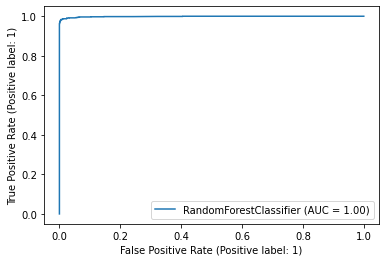

In [64]:
plot_roc_curve(Final_model,x_test,y_test)
plt.show()

In [65]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)

RandomForestClassifier()

In [66]:
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[1154,    1],
       [  10, 1093]], dtype=int64)

In [67]:
import joblib
joblib.dump(Final_model,"FinalModelSpamDetection.pkl")

['FinalModelSpamDetection.pkl']